# Обучение нейронной сети для классификации изображений
В качестве датасета взяты изображения дорог в Бразилии разделенные на три категории - асфальтированные, мощенные и грунтовые

Источник: https://github.com/thiagortk/Road-surface-detection-and-differentiation-considering-surface-damages

Обучение производилось на локально развернутом jupyter-notebook

In [1]:
# Импортируем необходимые библиотеки
import matplotlib
matplotlib.use("Agg")
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [2]:
# Загружаем изображения
print("[INFO] loading images...")
data = []
labels = []
imagePaths = sorted(list(paths.list_images(r"C:\Users\User\Desktop\Exercise2\data")))
print(f"[INFO] Number of loading images {len(imagePaths)}")
random.shuffle(imagePaths)

# Извлекаем метки 
for imagePath in imagePaths:	
	try:
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (32, 32)).flatten()
		data.append(image)
		label = imagePath.split(os.path.sep)[-2] 	
		labels.append(label)
	except Exception as e:
		print(str(e))

[INFO] loading images...
[INFO] Number of loading images 20760


In [3]:
# Нормализация данных
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
# Разбиваем данные на треннировачные и тестовые
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)


In [4]:
# Бинаризируем лейблы
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [5]:
# Архитектура модели
# 3072-1024-512-3
model = Sequential()
model.add(Dense(1024, input_shape=(3072,), activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

In [6]:
# Обучаем нейросеть
INIT_LR = 0.01
EPOCHS = 100
print("[INFO] training network...")
opt = SGD(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, 
              metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              epochs=EPOCHS, batch_size=1000)

[INFO] training network...
Epoch 1/100
16/16 [==============================] - 3s 137ms/step - loss: 1.0328 - accuracy: 0.5057 - val_loss: 0.8420 - val_accuracy: 0.5836
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.8166 - accuracy: 0.6057 - val_loss: 0.7877 - val_accuracy: 0.5985
Epoch 3/100
16/16 [==============================] - 2s 115ms/step - loss: 0.7811 - accuracy: 0.6249 - val_loss: 0.7221 - val_accuracy: 0.6815
Epoch 4/100
16/16 [==============================] - 2s 110ms/step - loss: 0.7420 - accuracy: 0.6496 - val_loss: 0.6956 - val_accuracy: 0.7137
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 0.6977 - accuracy: 0.7060 - val_loss: 0.6971 - val_accuracy: 0.6963
Epoch 6/100
16/16 [==============================] - 2s 105ms/step - loss: 0.7300 - accuracy: 0.6421 - val_loss: 0.6877 - val_accuracy: 0.6784
Epoch 7/100
16/16 [==============================] - 2s 116ms/step - loss: 0.7011 - accuracy: 0.6685 - val_loss: 0.

[INFO] evaluating network...
163/163 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

     asphalt       0.93      0.96      0.95      2043
       paved       0.95      0.92      0.93      1721
     unpaved       0.98      0.97      0.98      1426

    accuracy                           0.95      5190
   macro avg       0.95      0.95      0.95      5190
weighted avg       0.95      0.95      0.95      5190



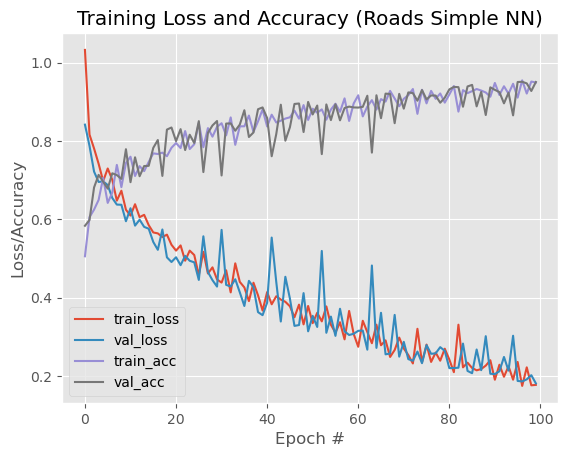

In [7]:
%matplotlib inline
# Оценка нейросети
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

# Графики потерь и точности
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Roads Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [8]:
# Сохранение модели
print("[INFO] serializing network and label binarizer...")
model.save(r"C:\Users\User\Desktop\Exercise2\roads_model.h5", save_format="h5")
with open(r"C:\Users\User\Desktop\Exercise2\roads_label_bin", "wb") as f:
  f.write(pickle.dumps(lb))

[INFO] serializing network and label binarizer...


# Проверка обученной модели пользовательскими данными


In [1]:
from keras.models import load_model
import argparse
import pickle
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
# Загружаем модель
from keras import models    
print("[INFO] loading network and label binarizer...")
model = models.load_model("/content/roads_model.h5")
lb = pickle.loads(open("/content/roads_label_bin", "rb").read())

[INFO] loading network and label binarizer...


In [4]:
# Функция для тестирования модели на пользовательских изображениях
def test_image():
  # Загружаем пользовательский файл, производим предварительную обработку
  uploaded = files.upload() 

  image = cv2.imread(list(uploaded.keys())[0])
  output = image.copy()
  image = cv2.resize(image, (32, 32))
  image = image.flatten()
  image = image.astype("float") / 255.0
  image = image.reshape((1, image.shape[0]))
  # По модели находим прогноз для загруженного изображения
  preds = model.predict(image)
  print(preds)
  # Выводим прогноз
  i = preds.argmax(axis=1)[0]
  label = lb.classes_[i]
  text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
  _ = cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
    (0, 0, 255), 2)
  cv2_imshow(output)

## Изображение дороги #1

---



Saving test_asphalt_1.jpg to test_asphalt_1.jpg
1/1 [==============================] - 3s 3s/step
[[0.85826015 0.13066396 0.01107583]]


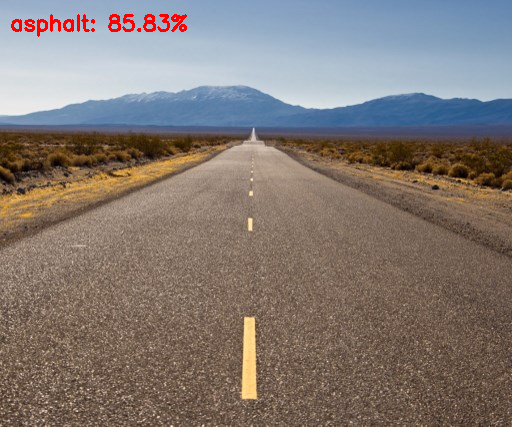

In [5]:
test_image()


## Изображение дороги #2

---



Saving test_asphalt_2.jpg to test_asphalt_2.jpg
1/1 [==============================] - 0s 19ms/step
[[0.06833892 0.28418326 0.6474778 ]]


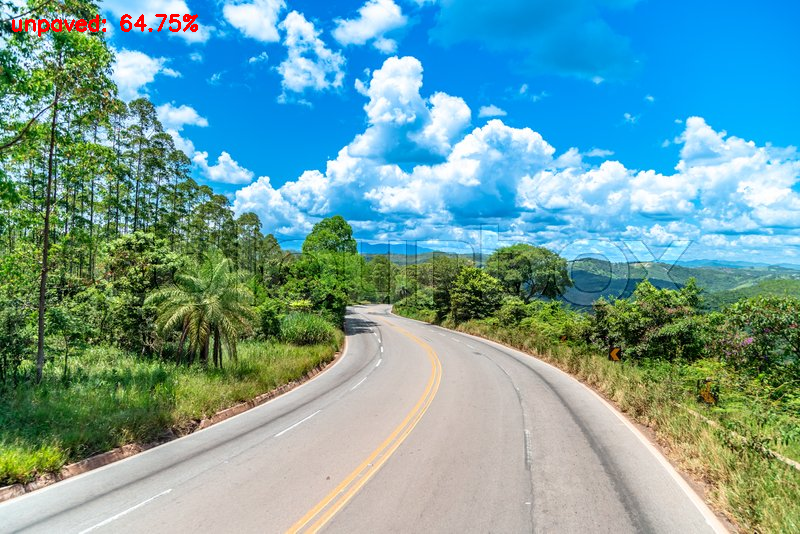

In [6]:
test_image()


## Изображение мощенной дороги #1

---



Saving test_paved_1.png to test_paved_1.png
1/1 [==============================] - 0s 29ms/step
[[0.20276405 0.611707   0.18552895]]


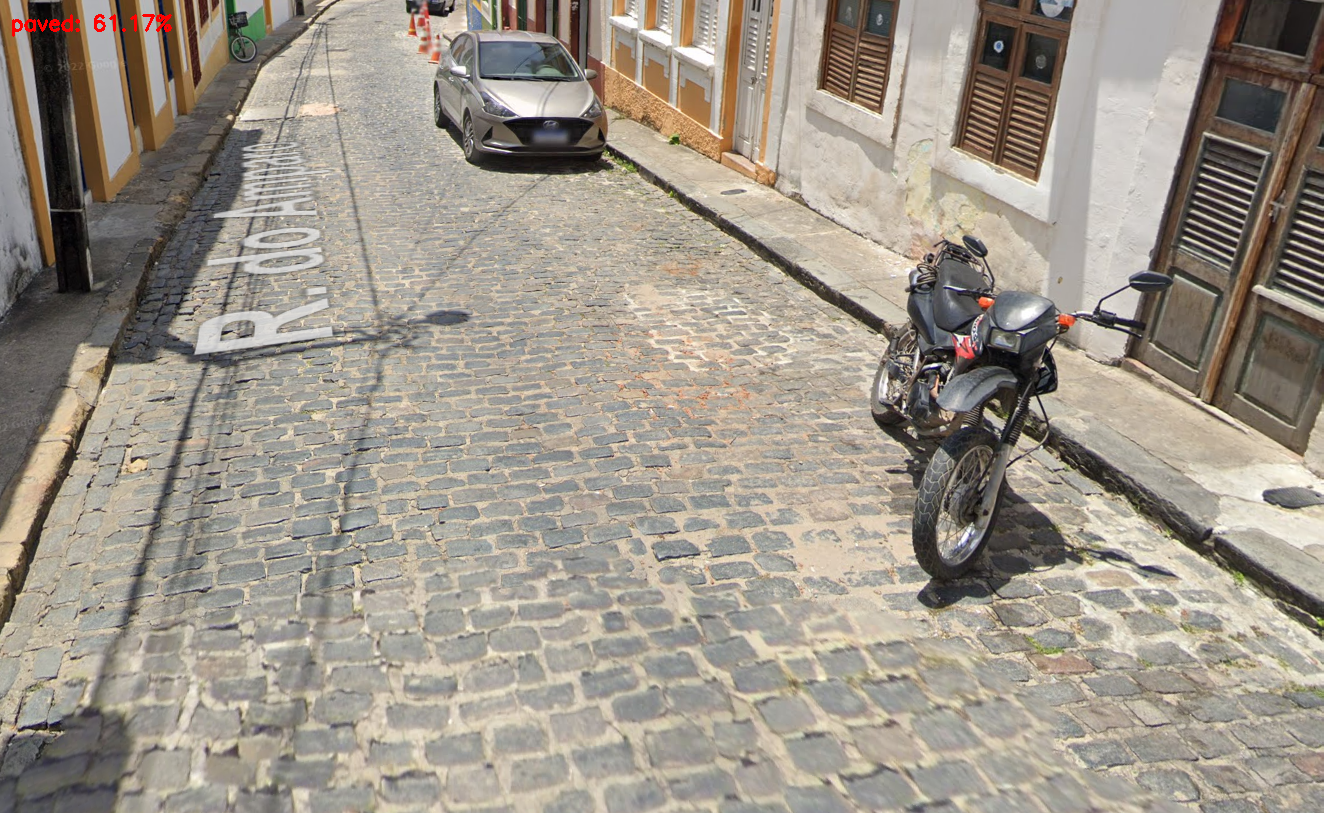

In [7]:
test_image()


## Изображение мощенной дороги #2

---



Saving test_paved_2.jpg to test_paved_2.jpg
1/1 [==============================] - 0s 29ms/step
[[0.7975655  0.20149909 0.00093546]]


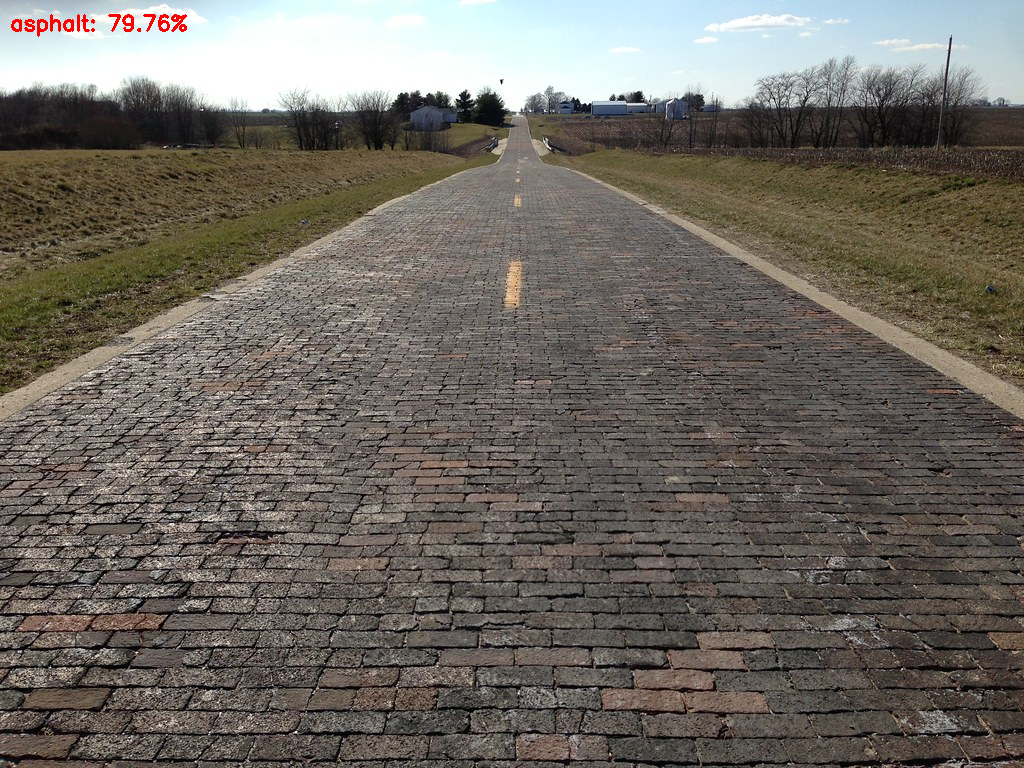

In [8]:
test_image()


## Изображение грунтовой дороги #1

---



Saving test_unpaved_1.jpg to test_unpaved_1.jpg
1/1 [==============================] - 0s 22ms/step
[[0.0660621  0.02930479 0.90463316]]


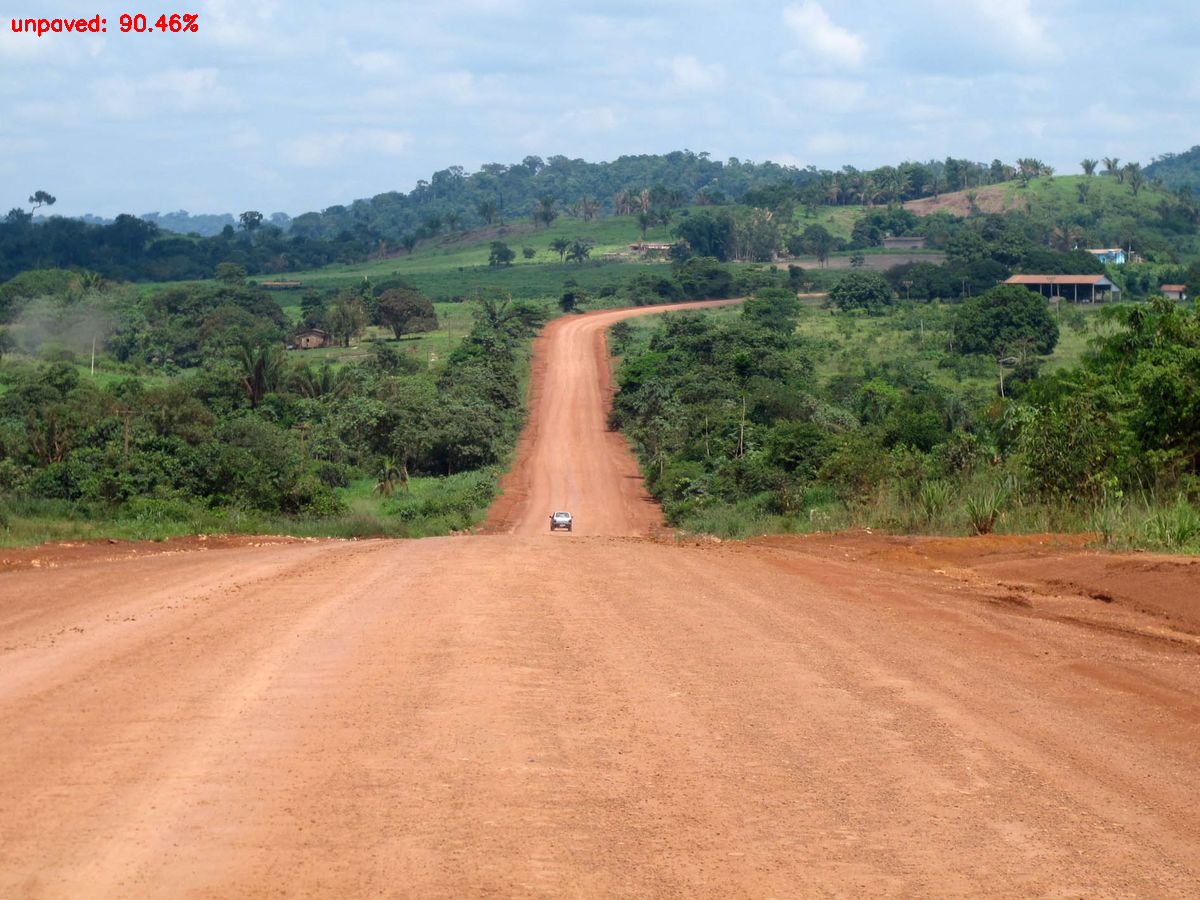

In [9]:
test_image()


## Изображение грунтовой дороги #2

---



Saving test_unpaved_2.jpg to test_unpaved_2.jpg
1/1 [==============================] - 0s 21ms/step
[[0.5445847  0.40701982 0.04839554]]


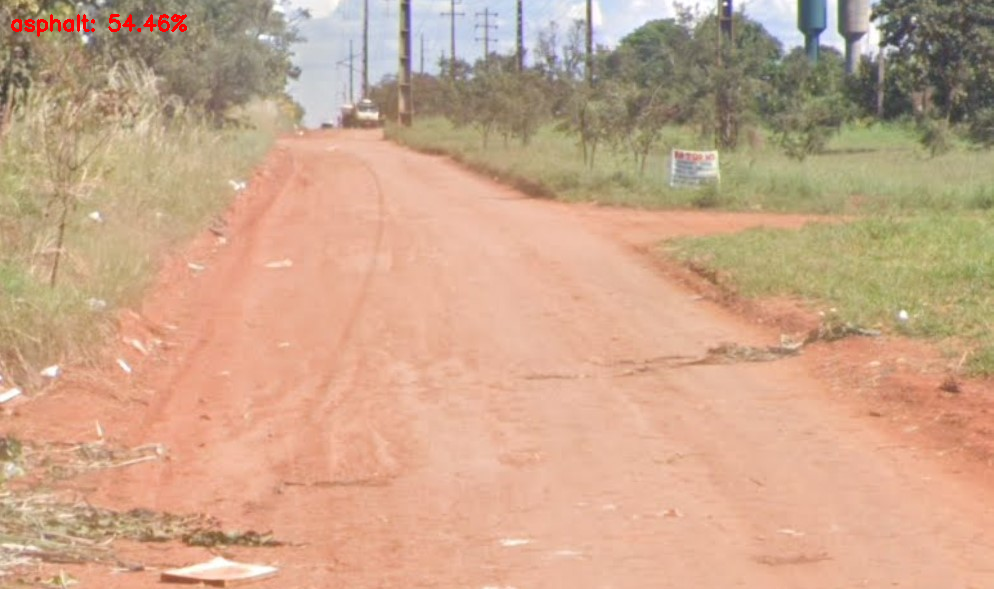

In [10]:
test_image()


## Вывод
После проверки изображениями из интернета, становится ясно, что модель дает верные предсказания только в случае если изображения по углу съемки и в целом похожи по виду на те, по которым происходило обучение, если же вид изображения изменяется, то ошибка становится довольно большой.